In [189]:
import torch
from torch import nn
from torch.utils.data import Dataset

In [190]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 100

In [191]:
# batch size x time x bands
valid = torch.rand((32, 128, 64))

In [192]:
class HeadBlock(nn.Module):
    def __init__(self, input_features: int, output_classes: int):
        super().__init__()
        self.intermediate_features = input_features // 2

        self.layers = nn.ModuleList(
            [
                nn.Flatten(),
                nn.Linear(input_features, self.intermediate_features),
                nn.ReLU(),
                nn.Linear(self.intermediate_features, output_classes),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [193]:
block_test = HeadBlock(8192, 5)
block_test(valid).shape

torch.Size([32, 5])

In [194]:
class FeatureExtractionBlock(nn.Module):
    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        conv_kernel_size: int = 1,
        conv_stride: int = 1,
        conv_padding: int = 0,
        pooling_kernel_size: int = 2,
    ):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Conv1d(
                    input_channels,
                    output_channels,
                    kernel_size=conv_kernel_size,
                    stride=conv_stride,
                    padding=conv_padding,
                ),
                nn.AvgPool1d(kernel_size=pooling_kernel_size),
                nn.BatchNorm1d(output_channels),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

In [195]:
extraction_test = FeatureExtractionBlock(128, 32)
extraction_test(valid).shape

torch.Size([32, 32, 32])

In [196]:
class BirdClassifier(nn.Module):
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        extractor_layers: int,
        validation_tensor: torch.Tensor,
    ):
        super().__init__()
        # Entry extractor
        self.entry_extractor_output_channels = input_channels * 2
        self.entry_extractor = FeatureExtractionBlock(
            input_channels, self.entry_extractor_output_channels
        )

        self.extraction_blocks = nn.ModuleList(
            [
                FeatureExtractionBlock(
                    self.entry_extractor_output_channels,
                    self.entry_extractor_output_channels,
                )
                for _ in range(extractor_layers)
            ]
        )

        entry_output = self.entry_extractor(validation_tensor)
        extraction_output = entry_output
        for layer in self.extraction_blocks:
            extraction_output = layer(extraction_output)

        head_input_features = extraction_output.shape[1] * extraction_output.shape[2]
        self.head = HeadBlock(head_input_features, output_classes)

    def forward(self, x):
        out = x

        out = self.entry_extractor(x)

        for layer in self.extraction_blocks:
            out = layer(out)

        return self.head(out)

In [197]:
class BirdClassifierManager:
    def __init__(
        self,
        output_classes: int,
        input_channels: int,
        extractor_layers: int,
        validation_tensor: torch.Tensor,
        load_model: bool = False,
        model_path="./bird_classifier.pth",
    ):
        self.model_path = model_path
        if load_model:
            self.load_model()
        else:
            self.model = BirdClassifier(
                output_classes, input_channels, extractor_layers, validation_tensor
            )

        self.validation_tensor = validation_tensor

    def validate(self):
        try:
            self.model(self.validation_tensor)
            print("OK!")
        except Exception as e:
            print(f"Validation failed: {e}")

    def predict(self, sample: torch.Tensor):
        pass

    def save_model(self):
        torch.save(self.model, self.model_path)

    def load_model(self):
        self.model = torch.load(self.model_path)

    def train(self, train: Dataset, valid: Dataset):
        pass

    def test(self, test: Dataset):
        pass

In [198]:
manager = BirdClassifierManager(5, 128, 2, valid)

In [199]:
manager.validate()

OK!


In [ ]:
import os
import torchaudio
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [172]:
class BirdSongDataset(Dataset):
    def __init__(
        self,
        x: pd.DataFrame,
        y: pd.DataFrame,
        sample_rate: int,
        num_samples: int,
        as_mel_spectogram: bool = True,
    ):
        super().__init__()
        self.x = x
        self.y = y
        self.target_sample_rate = sample_rate
        self.target_number_of_samples = num_samples
        self.as_mel_spectogram = as_mel_spectogram
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.target_sample_rate, n_fft=1024, hop_length=512, n_mels=64
        )

    def _resample_if_necessary(self, waveform: torch.Tensor, sample_rate: int):
        if sample_rate != self.target_sample_rate:
            resample_transform = torchaudio.transforms.Resample(
                orig_freq=sample_rate, new_freq=self.target_sample_rate
            )
            waveform = resample_transform(waveform)
        return waveform

    def _pad_or_trim(self, waveform: torch.Tensor):
        if waveform.shape[1] > self.target_number_of_samples:
            waveform = waveform[:, : self.target_number_of_samples]
        elif waveform.shape[1] < self.target_number_of_samples:
            padding = self.target_number_of_samples - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        return waveform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        path, class_ = self.x[index], self.y[index]

        waveform, sample_rate = torchaudio.load(str(path))
        waveform = self._resample_if_necessary(waveform, sample_rate)
        waveform = self._pad_or_trim(waveform)

        if self.as_mel_spectogram:
            waveform = self.mel_spectrogram_transform(waveform)

        return waveform, class_

In [173]:
class BirdSongDatasetManager:
    def __init__(
        self,
        csv_file_path: Path,
        audio_files_main_folder: Path,
        train: float = 0.8,
        valid: float = 0.1,
        test: float = 0.1,
        batch_size: int = 32,
        shuffle: bool = True,
        csv_file_name: str = "train_mod.csv",
        sample_rate: int = 32000,
        num_samples: int = 640000,
    ):
        if not np.isclose((train + valid + test), 1):
            raise Exception("Sum of dataset partitions must be equal to 1")

        self.csv_file_path = csv_file_path
        self.audio_files_main_folder = audio_files_main_folder
        self.train = train
        self.valid = valid
        self.test = test
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.csv_file_name = csv_file_name

        self.index_to_class, self.class_to_index = dict(), dict()

        self.dataframe, self.species_to_name = self._filter_data(
            self.csv_file_path, self.audio_files_main_folder
        )
        self.species_in_dataset = self.dataframe["ebird_code"].unique()

        self.mapped_dataframe = self._map_bird_to_path()

        self.dataset_loaders_args = dict(
            sample_rate=sample_rate, num_samples=num_samples
        )

    def _filter_data(
        self, csv_file_path: Path, audio_files_main_folder: Path
    ) -> pd.DataFrame:
        dataframe = pd.read_csv(csv_file_path)

        current_dataset_species = os.listdir(audio_files_main_folder)
        current_dataset_species.remove(self.csv_file_name)

        ebird_code_to_name = dict()
        class_ = 0
        for species in current_dataset_species:
            name = dataframe[dataframe["ebird_code"] == species].iloc[0]["species"]

            self.class_to_index[name] = class_
            self.index_to_class[class_] = name
            ebird_code_to_name[species] = name

            class_ += 1

        return (
            dataframe[dataframe["ebird_code"].isin(current_dataset_species)],
            ebird_code_to_name,
        )

    def _map_bird_to_path(self) -> pd.DataFrame:
        data = []
        for species in self.species_in_dataset:
            prefix = self.audio_files_main_folder / species
            audio_files = os.listdir(prefix)
            for file in audio_files:
                file_path = prefix / file

                class_code = self.species_to_name[species]
                data.append(
                    {
                        "class": self.class_to_index[class_code],
                        "file_path": file_path,
                        "class_name": class_code,
                        "ebird_code": species,
                    }
                )

        return pd.DataFrame(data)

    def get_datasets(self, with_valid: bool = True):
        train_data = []
        valid_data = []
        test_data = []

        for _, group in self.mapped_dataframe.groupby("ebird_code"):
            group = group.sample(frac=1, random_state=42).reset_index(drop=True)
            n = len(group)
            train_end = int(self.train * n)
            valid_end = train_end + int(self.valid * n) if with_valid else train_end

            train_data.append(group.iloc[:train_end])
            if with_valid:
                valid_data.append(group.iloc[train_end:valid_end])
                test_data.append(group.iloc[valid_end:])
            else:
                test_data.append(group.iloc[train_end:])

        train_df = pd.concat(train_data).reset_index(drop=True)
        valid_df = pd.concat(valid_data).reset_index(drop=True) if with_valid else None
        test_df = pd.concat(test_data).reset_index(drop=True)

        train = DataLoader(
            BirdSongDataset(
                train_df["file_path"], train_df["class"], **self.dataset_loaders_args
            ),
            batch_size=self.batch_size,
            shuffle=self.shuffle,
        )
        
        valid = (
            DataLoader(
                BirdSongDataset(
                    valid_df["file_path"],
                    valid_df["class"],
                    **self.dataset_loaders_args
                )
            )
            if with_valid
            else None
        )
        
        test = DataLoader(
            BirdSongDataset(
                test_df["file_path"], test_df["class"], **self.dataset_loaders_args
            )
        )

        return train, valid, test

In [174]:
manager = BirdSongDatasetManager(Path("data/train_mod.csv"), Path("data"))

In [175]:
manager.mapped_dataframe

,class,file_path,class_name,ebird_code
0,0,data\cacwre\XC11493.wav,Cactus Wren,cacwre
1,0,data\cacwre\XC132895.wav,Cactus Wren,cacwre
2,0,data\cacwre\XC140127.wav,Cactus Wren,cacwre
3,0,data\cacwre\XC140128.wav,Cactus Wren,cacwre
4,0,data\cacwre\XC146149.wav,Cactus Wren,cacwre
...,...,...,...,...
3923,46,data\foxspa\XC62943.wav,Red Fox Sparrow,foxspa
3924,46,data\foxspa\XC70105.wav,Red Fox Sparrow,foxspa
3925,46,data\foxspa\XC70109.wav,Red Fox Sparrow,foxspa
3926,46,data\foxspa\XC70110.wav,Red Fox Sparrow,foxspa


In [176]:
train, valid, test = manager.get_datasets()

In [177]:
x = next(iter(train))
x[0].shape

torch.Size([32, 1, 64, 1251])

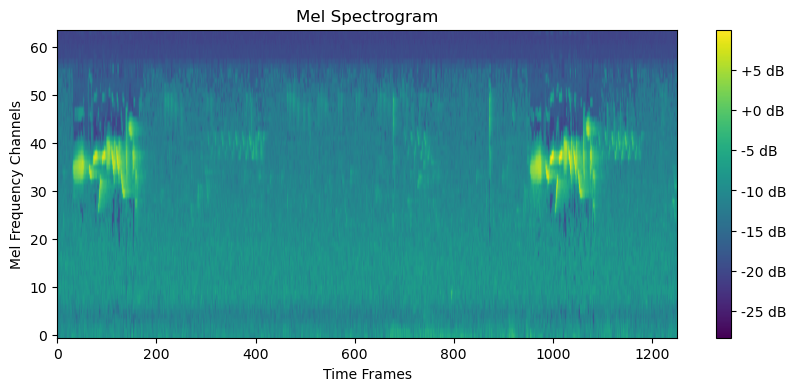

In [178]:
plt.figure(figsize=(10, 4))
plt.imshow(x[0][5].log2()[0, :, :].numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Channels")
plt.show()